# Import Libraries

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import random
import torch

print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Setup complete. Using torch 2.3.1+cu118 (NVIDIA GeForce MX250)


# Setup YOLOv7

In [2]:
#! git clone https://github.com/WongKinYiu/yolov7
! cd yolov7
! pip install -r ./yolov7/requirements.txt
#! wget https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7.pt
! cd ../

  Using cached PyYAML-6.0.1-cp310-cp310-win_amd64.whl.metadata (2.1 kB)
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
     ---------------------------------------- 0.0/60.8 kB ? eta -:--:--
     ------ --------------------------------- 10.2/60.8 kB ? eta -:--:--
     ------ --------------------------------- 10.2/60.8 kB ? eta -:--:--
     ------------------- ------------------ 30.7/60.8 kB 325.1 kB/s eta 0:00:01
     ------------------- ------------------ 30.7/60.8 kB 325.1 kB/s eta 0:00:01
     ------------------------- ------------ 41.0/60.8 kB 151.3 kB/s eta 0:00:01
     -------------------------------- ----- 51.2/60.8 kB 163.8 kB/s eta 0:00:01
     -------------------------------------- 60.8/60.8 kB 179.2 kB/s eta 0:00:00
  Using cached tqdm-4.66.4-py3-none-any.whl.metadata (57 kB)
  Using cached tensorboard-2.17.0-py3-none-any.whl.metadata (1.6 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached thop-0.1.1.post2209072238-py3-none

  You can safely remove it manually.
  You can safely remove it manually.


In [3]:
os.mkdir('./yolov7/dataset')
os.mkdir('./yolov7/dataset/train')
os.mkdir('./yolov7/dataset/train/images')
os.mkdir('./yolov7/dataset/train/labels')
os.mkdir('./yolov7/dataset/test')
os.mkdir('./yolov7/dataset/test/images')
os.mkdir('./yolov7/dataset/test/labels')

In [7]:
train_path = "./yolov7/dataset/train"
test_path = "./yolov7/dataset/test"

In [6]:
! cp {dataset_path}/images/images/train/* {train_path}/images/
! cp {dataset_path}/labels/labels/train/* {train_path}/labels/
! cp {dataset_path}/images/images/valid/* {test_path}/images/
! cp {dataset_path}/labels/labels/train/* {test_path}/labels/

In [8]:
train_images = os.listdir(train_path+'/images')
test_images = os.listdir(test_path+'/images')

# Visualization of Training Dataset

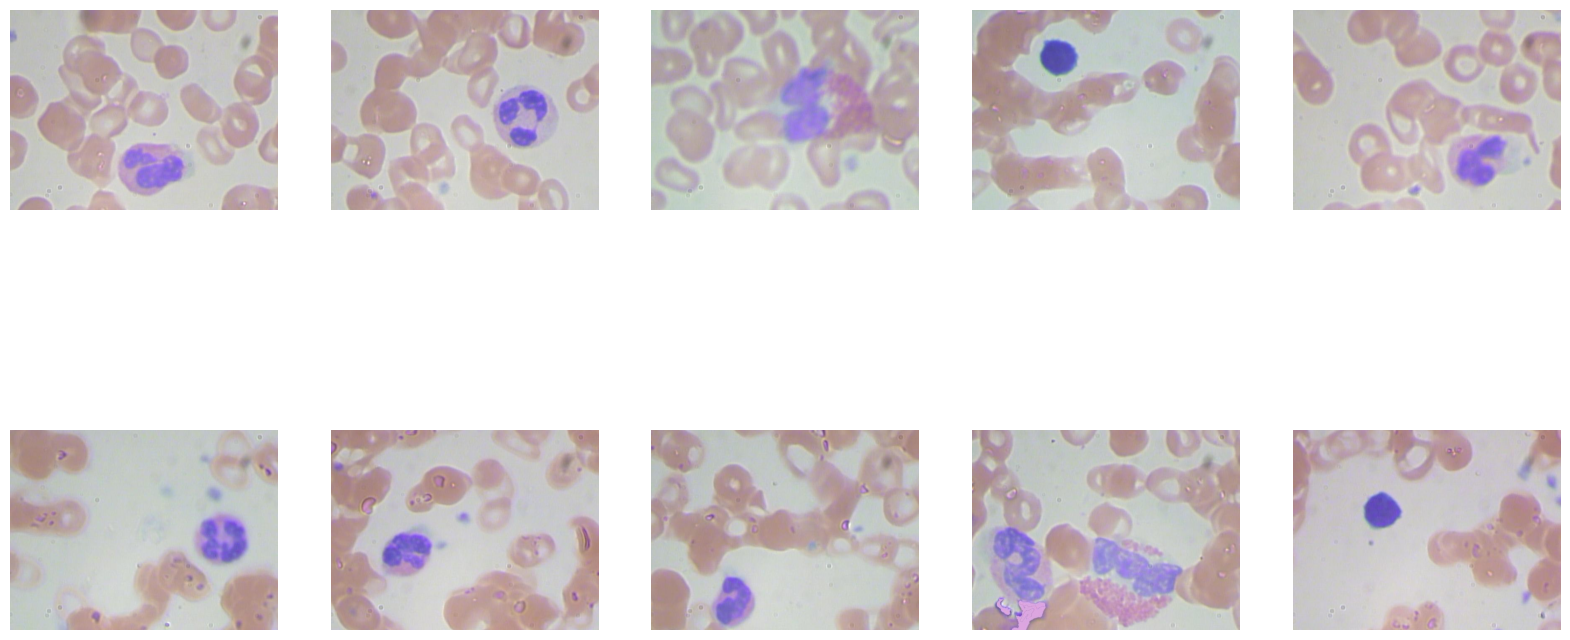

In [9]:
plt.figure(figsize=(20,10))
for i, c in enumerate(np.random.randint(0, len(train_images), size=10), start=1):
    plt.subplot(2,5,i)
    im = plt.imread(train_path+'/images/'+train_images[c])
    plt.axis('off')
    plt.imshow(im, cmap='gray')

# Using YoLo v7 and Train on Custom Dataset

### Editing coco.yaml file

In [6]:
text = """
train: ./yolov7/dataset/train
val: ./yolov7/dataset/test

# number of classes
nc: 3

# class names
names: ['Platelets', 'RBC', 'WBC']
"""
with open("./yolov7/data/coco.yaml", 'w') as file:
    file.write(text)

### Expand to see yolov5.yaml file

In [7]:
text = """
# parameters
nc: 3  # number of classes
depth_multiple: 1.0  # model depth multiple
width_multiple: 1.0  # layer channel multiple

# anchors
anchors:
  - [12,16, 19,36, 40,28]  # P3/8
  - [36,75, 76,55, 72,146]  # P4/16
  - [142,110, 192,243, 459,401]  # P5/32

# yolov7 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [32, 3, 1]],  # 0
  
   [-1, 1, Conv, [64, 3, 2]],  # 1-P1/2      
   [-1, 1, Conv, [64, 3, 1]],
   
   [-1, 1, Conv, [128, 3, 2]],  # 3-P2/4  
   [-1, 1, Conv, [64, 1, 1]],
   [-2, 1, Conv, [64, 1, 1]],
   [-1, 1, Conv, [64, 3, 1]],
   [-1, 1, Conv, [64, 3, 1]],
   [-1, 1, Conv, [64, 3, 1]],
   [-1, 1, Conv, [64, 3, 1]],
   [[-1, -3, -5, -6], 1, Concat, [1]],
   [-1, 1, Conv, [256, 1, 1]],  # 11
         
   [-1, 1, MP, []],
   [-1, 1, Conv, [128, 1, 1]],
   [-3, 1, Conv, [128, 1, 1]],
   [-1, 1, Conv, [128, 3, 2]],
   [[-1, -3], 1, Concat, [1]],  # 16-P3/8  
   [-1, 1, Conv, [128, 1, 1]],
   [-2, 1, Conv, [128, 1, 1]],
   [-1, 1, Conv, [128, 3, 1]],
   [-1, 1, Conv, [128, 3, 1]],
   [-1, 1, Conv, [128, 3, 1]],
   [-1, 1, Conv, [128, 3, 1]],
   [[-1, -3, -5, -6], 1, Concat, [1]],
   [-1, 1, Conv, [512, 1, 1]],  # 24
         
   [-1, 1, MP, []],
   [-1, 1, Conv, [256, 1, 1]],
   [-3, 1, Conv, [256, 1, 1]],
   [-1, 1, Conv, [256, 3, 2]],
   [[-1, -3], 1, Concat, [1]],  # 29-P4/16  
   [-1, 1, Conv, [256, 1, 1]],
   [-2, 1, Conv, [256, 1, 1]],
   [-1, 1, Conv, [256, 3, 1]],
   [-1, 1, Conv, [256, 3, 1]],
   [-1, 1, Conv, [256, 3, 1]],
   [-1, 1, Conv, [256, 3, 1]],
   [[-1, -3, -5, -6], 1, Concat, [1]],
   [-1, 1, Conv, [1024, 1, 1]],  # 37
         
   [-1, 1, MP, []],
   [-1, 1, Conv, [512, 1, 1]],
   [-3, 1, Conv, [512, 1, 1]],
   [-1, 1, Conv, [512, 3, 2]],
   [[-1, -3], 1, Concat, [1]],  # 42-P5/32  
   [-1, 1, Conv, [256, 1, 1]],
   [-2, 1, Conv, [256, 1, 1]],
   [-1, 1, Conv, [256, 3, 1]],
   [-1, 1, Conv, [256, 3, 1]],
   [-1, 1, Conv, [256, 3, 1]],
   [-1, 1, Conv, [256, 3, 1]],
   [[-1, -3, -5, -6], 1, Concat, [1]],
   [-1, 1, Conv, [1024, 1, 1]],  # 50
  ]

# yolov7 head
head:
  [[-1, 1, SPPCSPC, [512]], # 51
  
   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [37, 1, Conv, [256, 1, 1]], # route backbone P4
   [[-1, -2], 1, Concat, [1]],
   
   [-1, 1, Conv, [256, 1, 1]],
   [-2, 1, Conv, [256, 1, 1]],
   [-1, 1, Conv, [128, 3, 1]],
   [-1, 1, Conv, [128, 3, 1]],
   [-1, 1, Conv, [128, 3, 1]],
   [-1, 1, Conv, [128, 3, 1]],
   [[-1, -2, -3, -4, -5, -6], 1, Concat, [1]],
   [-1, 1, Conv, [256, 1, 1]], # 63
   
   [-1, 1, Conv, [128, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [24, 1, Conv, [128, 1, 1]], 
   
# route backbone P3
   [[-1, -2], 1, Concat, [1]],
   
   [-1, 1, Conv, [128, 1, 1]],
   [-2, 1, Conv, [128, 1, 1]],
   [-1, 1, Conv, [64, 3, 1]],
   [-1, 1, Conv, [64, 3, 1]],
   [-1, 1, Conv, [64, 3, 1]],
   [-1, 1, Conv, [64, 3, 1]],
   [[-1, -2, -3, -4, -5, -6], 1, Concat, [1]],
   [-1, 1, Conv, [128, 1, 1]], # 75
      
   [-1, 1, MP, []],
   [-1, 1, Conv, [128, 1, 1]],
   [-3, 1, Conv, [128, 1, 1]],
   [-1, 1, Conv, [128, 3, 2]],
   [[-1, -3, 63], 1, Concat, [1]],
   
   [-1, 1, Conv, [256, 1, 1]],
   [-2, 1, Conv, [256, 1, 1]],
   [-1, 1, Conv, [128, 3, 1]],
   [-1, 1, Conv, [128, 3, 1]],
   [-1, 1, Conv, [128, 3, 1]],
   [-1, 1, Conv, [128, 3, 1]],
   [[-1, -2, -3, -4, -5, -6], 1, Concat, [1]],
   [-1, 1, Conv, [256, 1, 1]], # 88
      
   [-1, 1, MP, []],
   [-1, 1, Conv, [256, 1, 1]],
   [-3, 1, Conv, [256, 1, 1]],
   [-1, 1, Conv, [256, 3, 2]],
   [[-1, -3, 51], 1, Concat, [1]],
   
   [-1, 1, Conv, [512, 1, 1]],
   [-2, 1, Conv, [512, 1, 1]],
   [-1, 1, Conv, [256, 3, 1]],
   [-1, 1, Conv, [256, 3, 1]],
   [-1, 1, Conv, [256, 3, 1]],
   [-1, 1, Conv, [256, 3, 1]],
   [[-1, -2, -3, -4, -5, -6], 1, Concat, [1]],
   [-1, 1, Conv, [512, 1, 1]], # 101
   
   [75, 1, RepConv, [256, 3, 1]],
   [88, 1, RepConv, [512, 3, 1]],
   [101, 1, RepConv, [1024, 3, 1]],

   [[102,103,104], 1, IDetect, [nc, anchors]],   

# Detect(P3, P4, P5)
  ]
"""

with open("./yolov7/cfg/training/yolov7.yaml", 'w') as file:
    file.write(text)

In [8]:
!wandb disabled

W&B disabled.


In [ ]:
#python ./yolov7/train.py --weights ./yolov7/yolov7.pt --cfg ./yolov7/cfg/training/yolov7.yaml --data ./yolov7/data/coco.yaml --batch-size 16 --epochs 100 --img-size 640 640 --hyp ./yolov7/data/hyp.scratch.custom.yaml --name run

In [ ]:
#! python ./yolov7/train.py --weights yolov7.pt --cfg ./yolov7/cfg/training/yolov7.yaml --data ./yolov7/data/coco.yaml \
#    --batch-size 16 --epochs 100 --img-size 640 640 --hyp ./yolov7/data/hyp.scratch.custom.yaml --name run

In [2]:
! ls ./runs/train/run
! ls ./runs/train/run

Folder PATH listing
Volume serial number is 60E7-D9AD
D:\DOWNLOADS\BLOOD-CELL-COUNTER-YOLO-V7-MAIN\BLOOD-CELL-COUNTER-YOLO-V7-MAIN\RUNS\TRAIN\RUN
+---weights


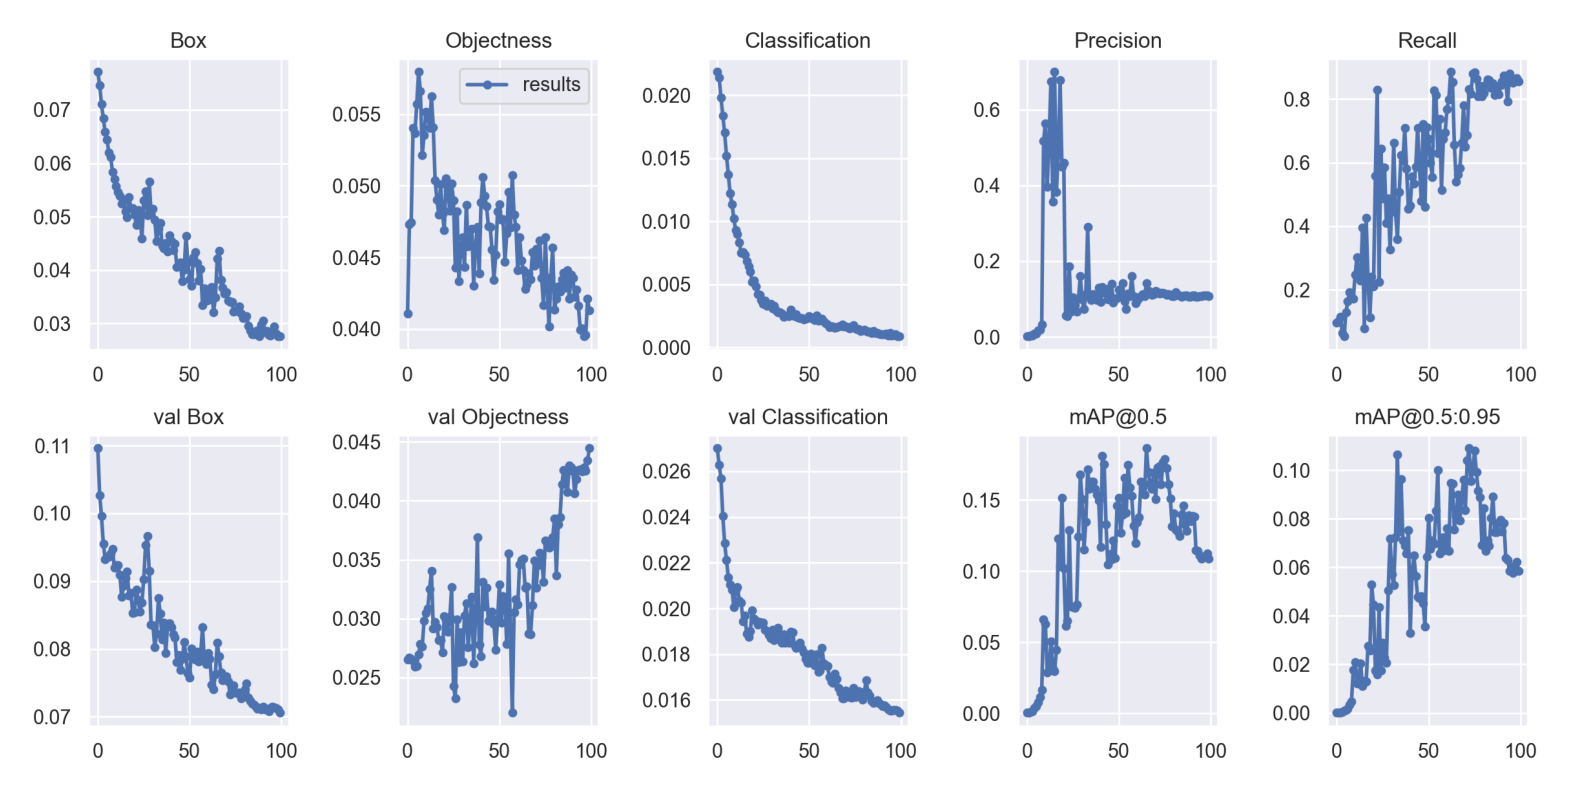

In [5]:
img = plt.imread('./runs/train/run/results.png')
plt.figure(figsize=(20,15))
plt.imshow(img)
plt.axis('off')
plt.show()

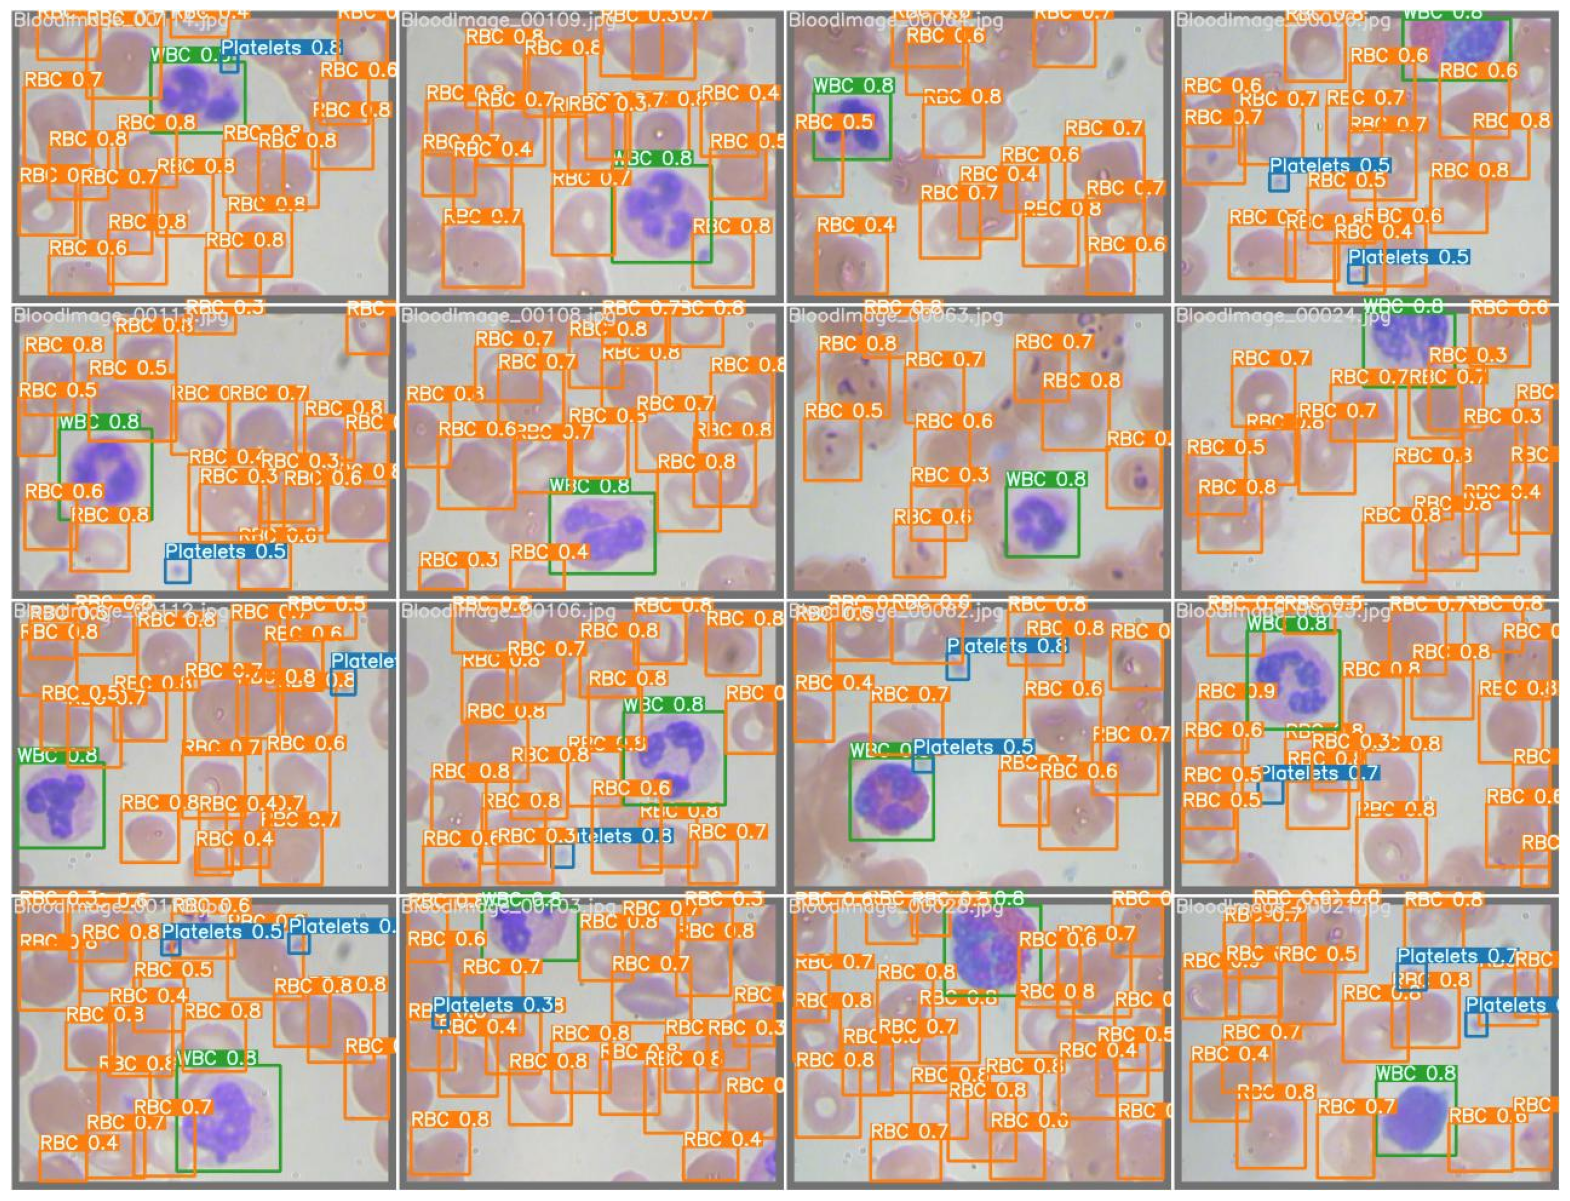

In [6]:
img = plt.imread('./runs/train/run/test_batch2_pred.jpg')
plt.figure(figsize=(20,20))
plt.imshow(img)
plt.axis('off')
plt.show()

# Inference

In [10]:
img = random.choice(test_images)
! python ./yolov7/detect.py  --weights ./runs/train/run/weights/best.pt --conf 0.5 --img-size 640 --source {test_path}/images/{img} --no-trace

Namespace(weights=['./runs/train/run/weights/best.pt'], source='./yolov7/dataset/test/images/BloodImage_00014.jpg', img_size=640, conf_thres=0.5, iou_thres=0.45, device='', view_img=False, save_txt=False, save_conf=False, nosave=False, classes=None, agnostic_nms=False, augment=False, update=False, project='runs/detect', name='exp', exist_ok=False, no_trace=True)
Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse
2 Plateletss, 12 RBCs, 1 WBC, Done. (1029.5ms) Inference, (16.2ms) NMS
 The image with the result is saved in: runs\detect\exp\BloodImage_00014.jpg
Done. (1.132s)


YOLOR  2024-5-30 torch 2.2.2+cpu CPU

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3550.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Model Summary: 314 layers, 36492560 parameters, 6194944 gradients, 103.2 GFLOPS


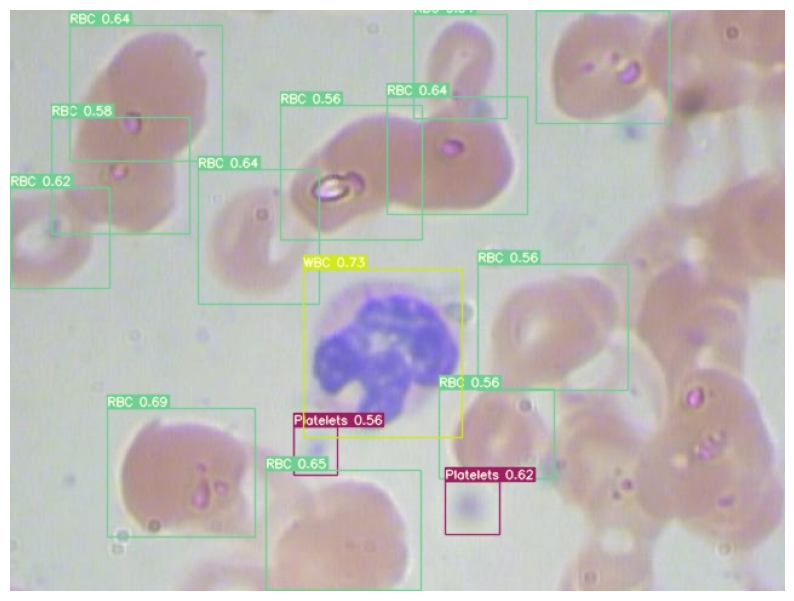

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
im = plt.imread('./runs/detect/exp/BloodImage_00014.jpg')
plt.axis('off')
plt.imshow(im)

In [5]:
! python ./yolov7/detect.py  --weights ./runs/train/run/weights/best.pt  --save-txt --conf 0.5 --img-size 640 --name /content/Output/test/ --source image.png --device cuda

Namespace(weights=['./runs/train/run/weights/best.pt'], source='image.png', img_size=640, conf_thres=0.5, iou_thres=0.45, device='cuda', view_img=False, save_txt=True, save_conf=False, nosave=False, classes=None, agnostic_nms=False, augment=False, update=False, project='runs/detect', name='/content/Output/test/', exist_ok=False, no_trace=False)
Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse
 Convert model to Traced-model... 
 traced_script_module saved! 
 model is traced! 

1 RBC, 6 WBCs, Done. (159.7ms) Inference, (85.6ms) NMS
 The image with the result is saved in: \content\Output\test5\image.png
Done. (0.863s)


YOLOR  2024-5-30 torch 2.3.1+cu118 CUDA:cuda (NVIDIA GeForce MX250, 2047.875MB)

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Model Summary: 314 layers, 36492560 parameters, 6194944 gradients, 103.2 GFLOPS


In [3]:
from PIL import Image
import os

# Folder Contain JPG and TXT
folder_path =   "/content/Output/test"

jpg_files = [f for f in os.listdir(folder_path) if f.endswith(".jpg")]
if len(jpg_files) > 0:
    jpg_file_path = os.path.join(folder_path, jpg_files[0])
    image = Image.open(jpg_file_path)
    image.show()
else:
    print("No JPG file found in the folder.")

txt_folder_path = os.path.join(folder_path, "labels")
txt_files = [f for f in os.listdir(txt_folder_path) if f.endswith(".txt")]
if len(txt_files) > 0:
    txt_file_path = os.path.join(txt_folder_path, txt_files[0])
    with open(txt_file_path, "r") as txt_file:
        lines = txt_file.readlines()
        wbc_count = 0
        rbc_count = 0
        platelets_count = 0
        for line in lines:
            items = line.strip().split(' ')
            class_val = int(items[0])
            if class_val == 2:
                wbc_count += 1
            elif class_val == 1:
                rbc_count += 1
            elif class_val == 0:
                platelets_count += 1


        print("-----------COUNTING RESULT----------")
        print("White Blood Cell (WBC) Detected = ", wbc_count)
        print("Red Blood Cell (RBC) Detected   = ", rbc_count)
        print("Platelets Detected              = ", platelets_count)
else:
    print("No TXT file found in the 'labels' folder.")

No JPG file found in the folder.
-----------COUNTING RESULT----------
White Blood Cell (WBC) Detected =  6
Red Blood Cell (RBC) Detected   =  1
Platelets Detected              =  0
